<a href="https://colab.research.google.com/github/samyachauhan/plant-disease-detection/blob/main/ML_Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data
from skimage.color import rgb2hsv
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import colorsys
import cv2
import time #timing models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image #to augment images
import requests
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
#Import from drive

!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20%2B%20X/Group/Environment/Plant%20Disease/plantdisease_metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20%2B%20X/Group/Environment/Plant%20Disease/plantdisease_image_data.npy"

# pre-loading all data of interest
metadata = pd.read_csv('plantdisease_metadata.csv')
image_data = np.load('plantdisease_image_data.npy')

plantdisease_metada 100%[===================>]   9.02K  --.-KB/s    in 0s      
plantdisease_image_ 100%[===================>]  32.16M   107MB/s    in 0.3s    


In [3]:
metadata

,index,split,class
0,0,train,1.0
1,1,train,0.0
2,2,train,1.0
3,3,train,1.0
4,4,train,0.0
...,...,...,...
681,681,test,0.0
682,682,test,0.0
683,683,test,1.0
684,684,test,0.0


Class 1.0 is healthy and 0.0 is unhealthy

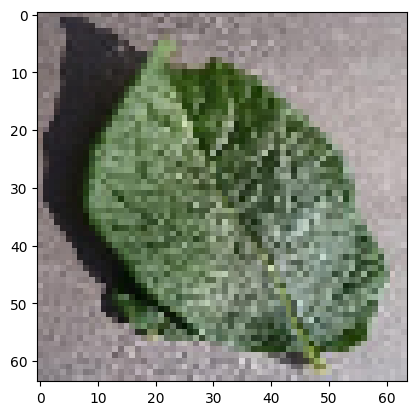

In [4]:
image_data
plt.imshow(image_data[0]) #healthy

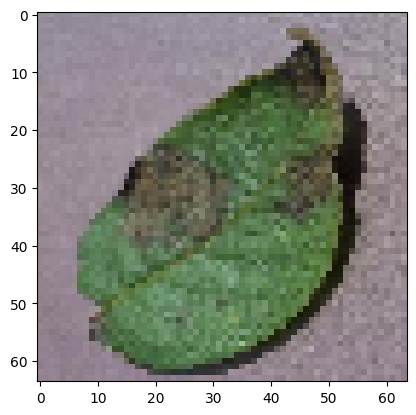

In [5]:
plt.imshow(image_data[1]) #unhealthy

#Data Exploration



1. Training data vs Testing data graph
2. Healthy vs Unhealthy data graph
3. Within Training and Testing how much is Healthy vs Unhealthy
4. Size of Images
5. Dimensions of Labels
6. Number of Images
7. Inputs vs Outputs (classification)

<Axes: xlabel='split', ylabel='count'>

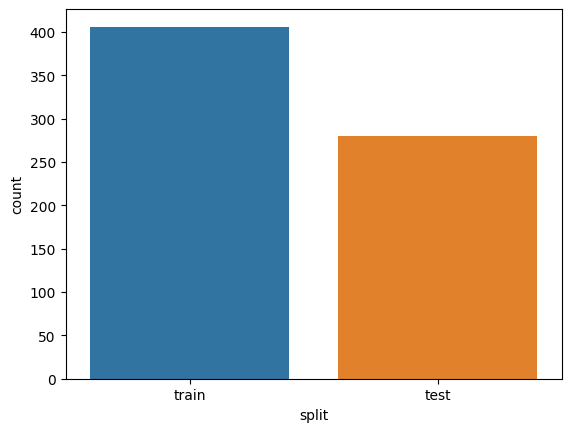

In [6]:
# training vs testing data split
sns.countplot(x = 'split', data = metadata)

<Axes: xlabel='class', ylabel='count'>

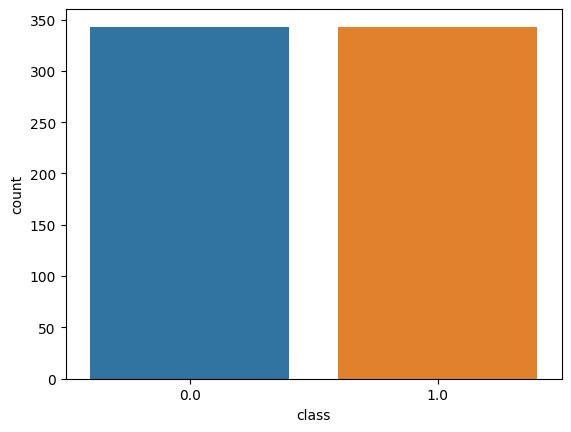

In [7]:
# healthy vs unhealthy data split
sns.countplot(x = 'class', data = metadata)

<Axes: xlabel='split', ylabel='count'>

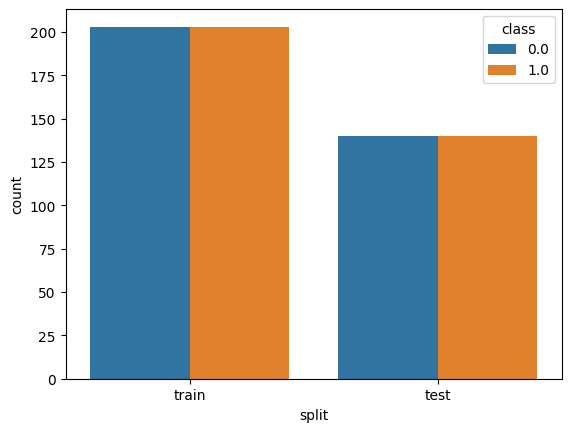

In [8]:
# healthy vs unhealthy dataset split within training and testing
sns.countplot(x = 'split', hue = 'class', data = metadata)

In [9]:
# size of images
print(np.shape(image_data))

(686, 64, 64, 3)


In [10]:
# dimensions of label set
print(np.shape(metadata))

(686, 3)


In [11]:
# number of images
arr = np.array(metadata)
splitData = arr[:, 1]
numberPictures = len(arr)

trainData = 0;
testData = 0;
for label in splitData:
  if (label == "train"):
    trainData = trainData + 1
  else:
    testData = testData + 1

print("Total Images: " + str(numberPictures))
print()
print("Training Data: " + str(trainData))
print("Testing Data: " + str(testData))

Total Images: 686

Training Data: 406
Testing Data: 280


In [12]:
# inputs vs outputs
classHealth = arr[:, 2]
totalHealthy = 0;
totalInfected = 0;
for label in classHealth:
  if (label == 1.0):
    totalHealthy = totalHealthy + 1
  else:
    totalInfected = totalInfected + 1


print("Input (images)")
print("Total Images: " + str(numberPictures))

print()

print("Output (classification)")
print("Healthy Plant Images: " + str(totalHealthy))
print("Infected Plant Images: " + str(totalInfected))

Input (images)
Total Images: 686

Output (classification)
Healthy Plant Images: 343
Infected Plant Images: 343


#Data Pre-Processing


1. Change labels into integers
2. Change RGB to HSV
3. Convert Images into 2D Array
4. Separate into Training Dataset and Testing Dataset


In [13]:
# labels to integer
labels = arr[:, 2]
#labels = categorical(labels)
labels = np.int_(labels)
print(labels)

[1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0
 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0
 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0
 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0
 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1
 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0
 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1
 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1
 1 1 0 1 1 1 1 0 0 1 0 0 

In [14]:
# RGB to HSV
hsvImages = []
hueImages = []
valueImages = []

for image in image_data:
  hsv_img = rgb2hsv(image)
  hsvImages.append(hsv_img) #hsvImage
  hue_img = hsv_img[:, :, 0]
  hueImages.append(hue_img) #hueImage
  value_img = hsv_img[:, :, 2]
  valueImages.append(value_img) #valueImage

print(np.shape(hsvImages))
print(np.shape(hueImages))
print(np.shape(valueImages))

(686, 64, 64, 3)
(686, 64, 64)
(686, 64, 64)


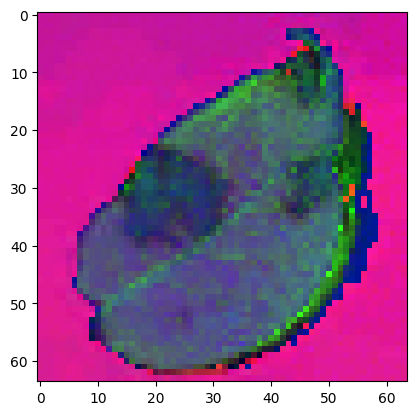

In [15]:
plt.imshow(hsvImages[1])

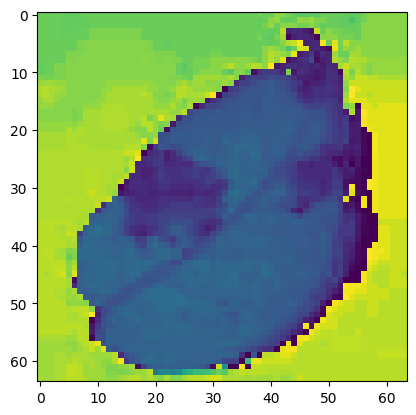

In [16]:
plt.imshow(hueImages[1])

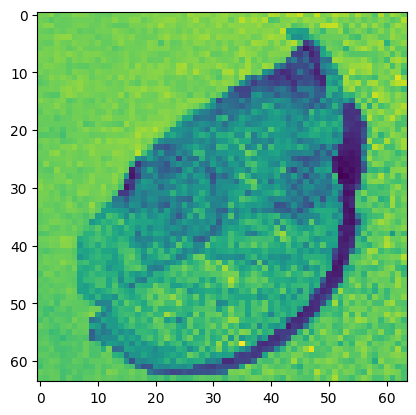

In [17]:
plt.imshow(valueImages[1])

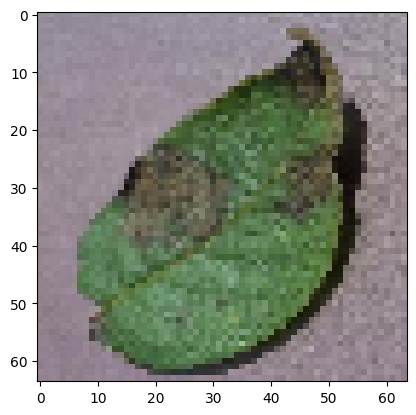

In [18]:
plt.imshow(image_data[1])

In [19]:
# convert into 2D array
def normalize_dataset (image):
  normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
  return normalized

normalizedImages = []
for image in hsvImages:
  image = image.flatten()
  normalizedImages.append(normalize_dataset(image))

normalizedImages = np.array(normalizedImages) #makes into array so it can be split later
np.shape(normalizedImages)

(686, 12288)

In [20]:
print(labels)

[1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0
 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0
 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0
 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0
 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1
 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0
 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1
 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1
 1 1 0 1 1 1 1 0 0 1 0 0 

In [21]:
trainingSize = 586
X_train = normalizedImages[0 : trainingSize, :]
y_train = labels[0 : trainingSize]
X_test = normalizedImages[trainingSize: , :]
y_test = labels[trainingSize:]

#Models

1. SVM
2. KNN
3. Naive Bayes
4. Random Forests
5. MLP




In [22]:
#SVM
tSVM = time.time() #tSVM is time it takes for model to run

SVM = svm.SVC(kernel='linear') # Linear Kernel
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
elapsedSVM = time.time() - tSVM
print("Linear Kernel Accuracy Percent:",metrics.accuracy_score(y_test, y_pred)*100)
print("Run Time(seconds): " + str(elapsedSVM))
print()


SVM = svm.SVC(kernel='rbf') # RBF Kernel
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
elapsedSVM = time.time() - tSVM
print("RBF Kernel Accuracy Percent:",metrics.accuracy_score(y_test, y_pred)*100)
print("Run Time(seconds): " + str(elapsedSVM))
print()


SVM = svm.SVC(kernel='sigmoid') # Sigmoid Kernel
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
elapsedSVM = time.time() - tSVM
print("Sigmoid Kernel Accuracy Percent:",metrics.accuracy_score(y_test, y_pred)*100)
print("Run Time(seconds): " + str(elapsedSVM))
print()


SVM = svm.SVC(kernel='poly') # Poly Kernel (graph?)
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
elapsedSVM = time.time() - tSVM
print("Poly Kernel Accuracy Percent:",metrics.accuracy_score(y_test, y_pred)*100)
print("Run Time(seconds): " + str(elapsedSVM))

Linear Kernel Accuracy Percent: 88.0
Run Time(seconds): 6.8134613037109375

RBF Kernel Accuracy Percent: 87.0
Run Time(seconds): 14.192266702651978

Sigmoid Kernel Accuracy Percent: 42.0
Run Time(seconds): 24.332465410232544

Poly Kernel Accuracy Percent: 89.0
Run Time(seconds): 31.855626583099365


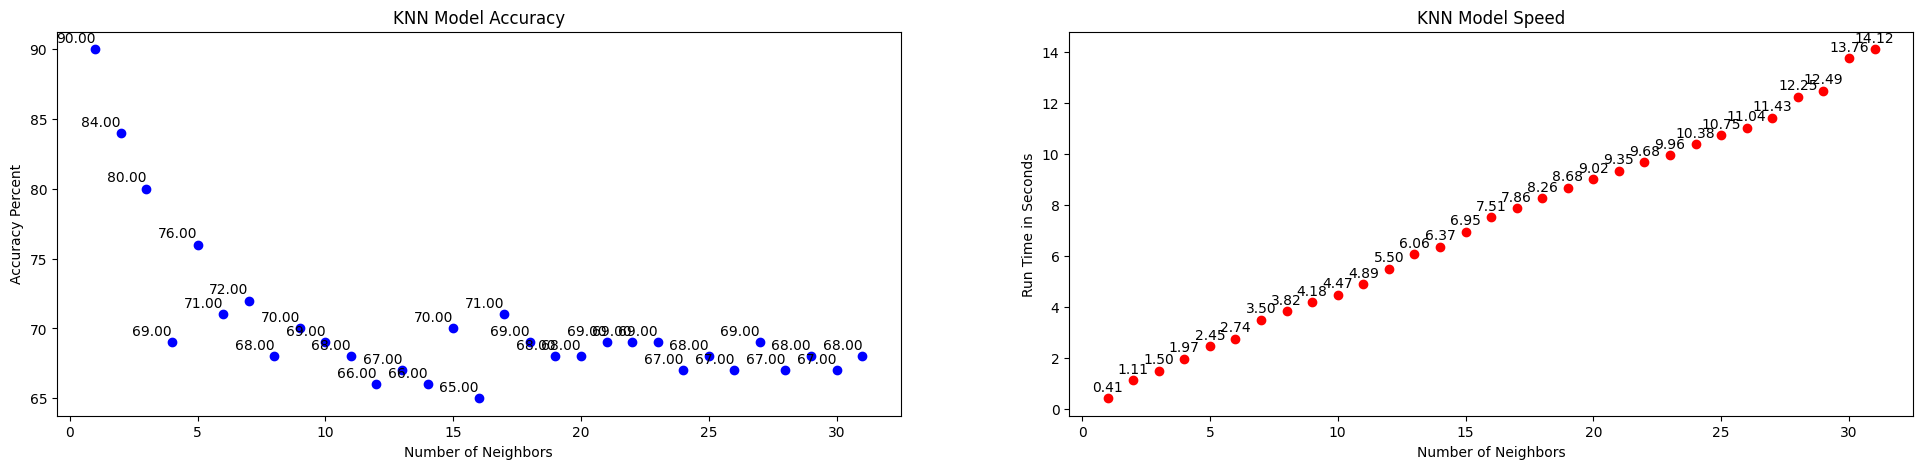

In [23]:
#KNN
n = 1 #n = number of neighbors
tKNN = time.time() #tKNN is time it takes for model to run
accuracyListKNN = []
timeListKNN = []
neighborList = []

while n <= 31:
  knn = KNeighborsClassifier(n_neighbors = n)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracyKNN = accuracy_score(y_test, y_pred) * 100
  accuracyListKNN.append(accuracyKNN)
  elapsedKNN = time.time() - tKNN
  timeListKNN.append(elapsedKNN)
  neighborList.append(n)
  n = n + 1


plt.subplot(1, 2, 1)
plt.scatter(neighborList, accuracyListKNN, color = "blue")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Percent")
plt.title("KNN Model Accuracy")
for x,y in zip(neighborList,accuracyListKNN):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='right')

plt.subplot(1, 2, 2)
plt.scatter(neighborList, timeListKNN, color = "red")
plt.xlabel("Number of Neighbors")
plt.ylabel("Run Time in Seconds")
plt.title("KNN Model Speed")
for x,y in zip(neighborList,timeListKNN):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

In [24]:
#Gaussian Naive Bayes
NB=GaussianNB()
tNB = time.time()
NB.fit(X_train,y_train)
y_pred=NB.predict(X_test)
elapsedNB = time.time() - tNB
print("Gaussian Naive Bayes Accuracy Percent: " + str(accuracy_score(y_pred,y_test) * 100))
print("Gaussian Naive Bayes Run Time (seconds): " + str(elapsedNB))

Gaussian Naive Bayes Accuracy Percent: 84.0
Gaussian Naive Bayes Run Time (seconds): 0.06404590606689453


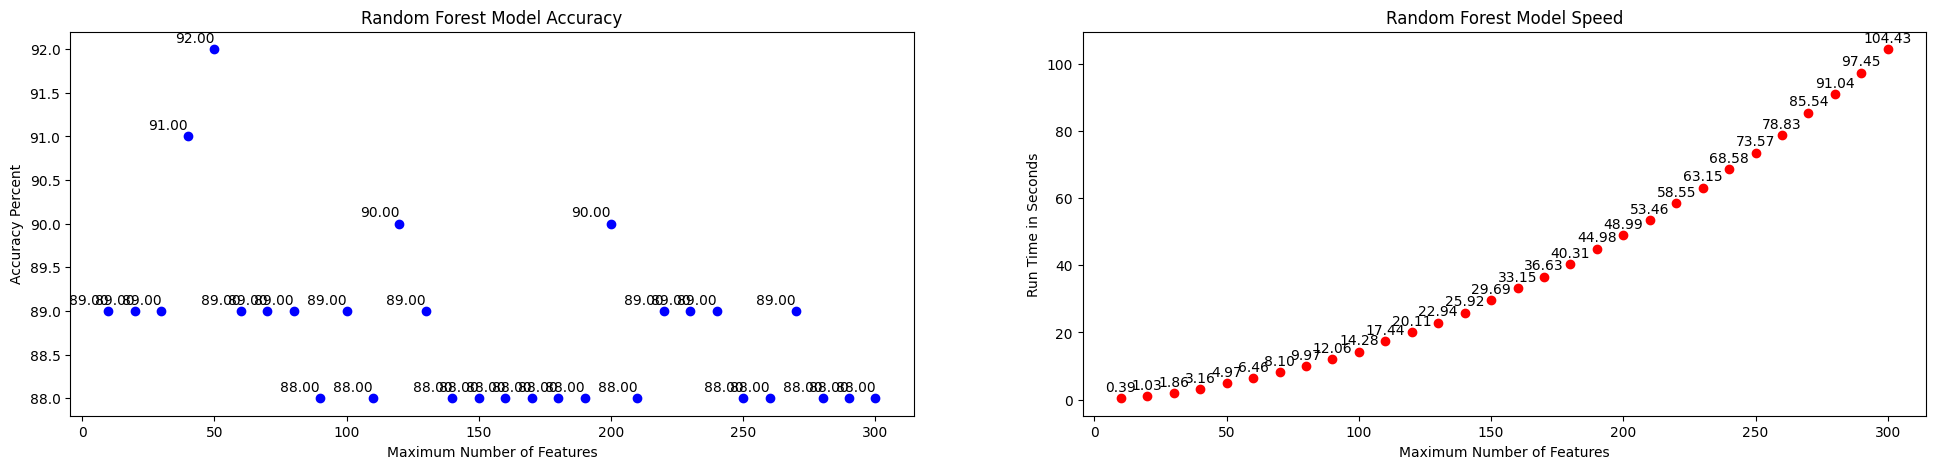

In [25]:
#Random Forest
RF=RandomForestClassifier()
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_pred,y_test) * 100

maxFeat = 10 #n = maximum number of features
tRF = time.time()
accuracyListRF = []
timeListRF = []
maxFeatList = []

while maxFeat <= 300:
  RF=RandomForestClassifier(max_features = maxFeat)
  RF.fit(X_train,y_train)
  y_pred = RF.predict(X_test)
  accuracyRF = accuracy_score(y_pred,y_test) * 100
  accuracyListRF.append(accuracyRF)
  elapsedRF = time.time() - tRF
  timeListRF.append(elapsedRF)
  maxFeatList.append(maxFeat)
  maxFeat = maxFeat + 10


plt.subplot(1, 2, 1)
plt.scatter(maxFeatList, accuracyListRF, color = "blue")
plt.xlabel("Maximum Number of Features")
plt.ylabel("Accuracy Percent")
plt.title("Random Forest Model Accuracy")
for x,y in zip(maxFeatList,accuracyListRF):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='right')

plt.subplot(1, 2, 2)
plt.scatter(maxFeatList, timeListRF, color = "red")
plt.xlabel("Maximum Number of Features")
plt.ylabel("Run Time in Seconds")
plt.title("Random Forest Model Speed")
for x,y in zip(maxFeatList,timeListRF):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

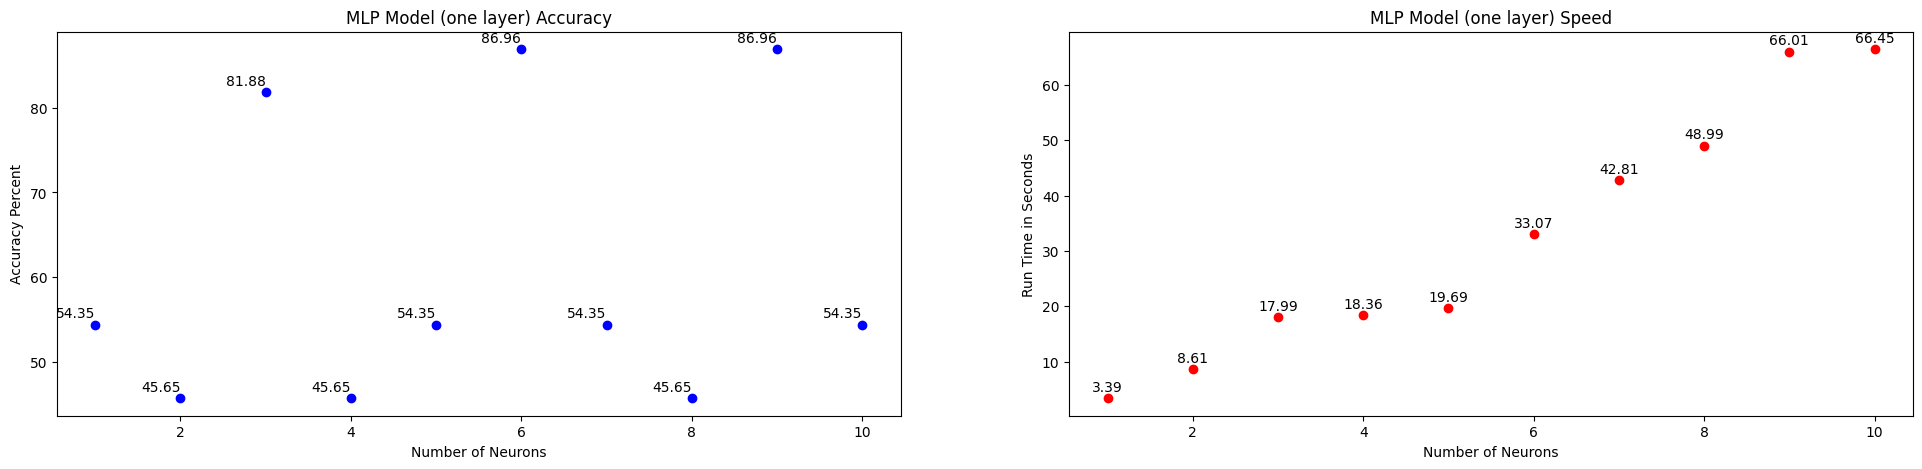

In [26]:
#MLP (one hidden layer)
XNN_train, XNN_test, yNN_train, yNN_test = train_test_split(normalizedImages, labels, test_size = 0.2, random_state = 35)
tMLP = time.time()
accuracyListMLP = []
timeListMLP = []
neuronNumberList = []
neurons = 1


while neurons <= 10:
  nnet = MLPClassifier(hidden_layer_sizes=(neurons), random_state=1, max_iter=100000)
  nnet.fit(XNN_train, yNN_train)
  predictions = nnet.predict(XNN_test)
  accuracyMLP = accuracy_score(yNN_test, predictions) * 100
  accuracyListMLP.append(accuracyMLP)
  elapsedMLP = time.time() - tMLP
  timeListMLP.append(elapsedMLP)
  neuronNumberList.append(neurons)
  neurons = neurons + 1


plt.subplot(1, 2, 1)
plt.scatter(neuronNumberList, accuracyListMLP, color = "blue")
plt.xlabel("Number of Neurons")
plt.ylabel("Accuracy Percent")
plt.title("MLP Model (one layer) Accuracy")
for x,y in zip(neuronNumberList,accuracyListMLP):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='right')

plt.subplot(1, 2, 2)
plt.scatter(neuronNumberList, timeListMLP, color = "red")
plt.xlabel("Number of Neurons")
plt.ylabel("Run Time in Seconds")
plt.title("MLP Model (one layer) Speed")
for x,y in zip(neuronNumberList,timeListMLP):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

In [27]:
#MLP (two hidden layers)
XNN_train, XNN_test, yNN_train, yNN_test = train_test_split(normalizedImages, labels, test_size = 0.2, random_state = 35)
tMLP = time.time()
neuron1 = 1
neuron2 = 1

while neuron1 <= 5:
  while neuron2 <=5:
    nnet = MLPClassifier(hidden_layer_sizes=(neuron1, neuron2), random_state=1, max_iter=100000)
    nnet.fit(XNN_train, yNN_train)
    nnet.fit(XNN_train, yNN_train)
    predictions = nnet.predict(XNN_test)
    elapsedMLP = time.time() - tMLP
    print("MLP Two Layer Testing Percent (" + str(neuron1) + "," + str(neuron2) + "): "  + str(accuracy_score(yNN_test, predictions)*100))
    print("Run Time(seconds): " + str(elapsedMLP))
    print()
    neuron2 = neuron2 + 1
  neuron1 = neuron1 + 1
  neuron2 = 1
  print()

MLP Two Layer Testing Percent (1,1): 45.65217391304348
Run Time(seconds): 13.576430082321167

MLP Two Layer Testing Percent (1,2): 45.65217391304348
Run Time(seconds): 23.1868257522583

MLP Two Layer Testing Percent (1,3): 54.347826086956516
Run Time(seconds): 30.945117950439453

MLP Two Layer Testing Percent (1,4): 54.347826086956516
Run Time(seconds): 40.08230423927307

MLP Two Layer Testing Percent (1,5): 54.347826086956516
Run Time(seconds): 44.716986894607544


MLP Two Layer Testing Percent (2,1): 45.65217391304348
Run Time(seconds): 60.37731957435608

MLP Two Layer Testing Percent (2,2): 54.347826086956516
Run Time(seconds): 72.95328116416931

MLP Two Layer Testing Percent (2,3): 85.5072463768116
Run Time(seconds): 94.21080017089844

MLP Two Layer Testing Percent (2,4): 83.33333333333334
Run Time(seconds): 113.1643590927124

MLP Two Layer Testing Percent (2,5): 78.98550724637681
Run Time(seconds): 130.53684163093567


MLP Two Layer Testing Percent (3,1): 76.81159420289855
Run Tim